In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../../code/')
import utils
import leakage
import reframed
import scipy
import statsmodels.api as sm
import seaborn as sns

# Estimate release rates for E. coli in glucose from Paczia et al. 2012

In [2]:
data_folder = Path('../../../data')
supp_figure_folder = Path('../../../SupplementalFigures')
figure_folder = Path('../../../Figures')
organism = 'e_coli'
exometabolites_folder = data_folder / 'paczia_2012' /f"{organism}"
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
# Use same value as for galactose -> also reasonably similiar to this literature value
# https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=109837
# Slightly lower than https://bmcbiophys.biomedcentral.com/articles/10.1186/2046-1682-6-4/tables/1

gDW_per_OD = 0.346 

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'e_coli')

In [5]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)
glucose_df = pd.read_csv(fn_glucose)

## Remove outliers

In [6]:
concentrations.loc[1, 'FUM'] = np.nan

# Read in OD values

In [7]:
df_OD = pd.read_csv(fn_OD, index_col=0)


Text(0, 0.5, 'ln(OD600)')

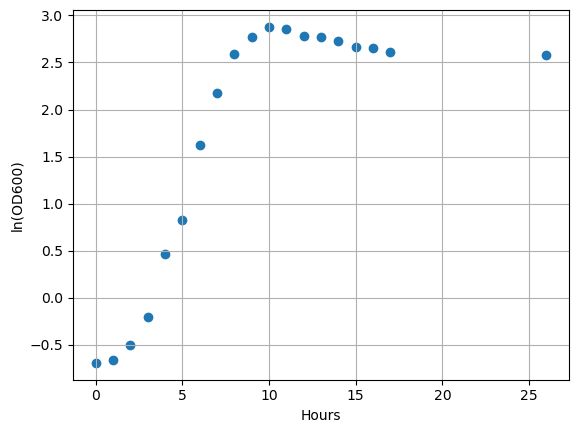

In [8]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

Text(0, 0.5, 'ln(OD600)')

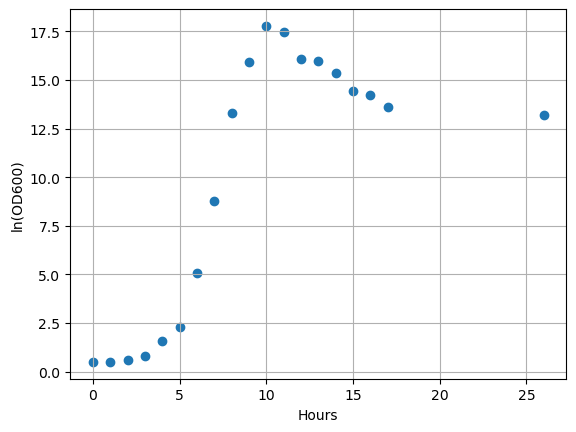

In [9]:
plt.scatter(df_OD.index, df_OD['OD mean'])
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

## Mapping

In [54]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv = {value:key for key, value in met_abrv_to_name.items()}


# Estimate biomass area under the curve (AUC)

## Simpson integration

In [55]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.514 0.175422
2 0.608 0.3649146666666666
3 0.817 0.6081238333333333
4 1.595 0.9959033333333331
5 2.295 1.6711223333333332
6 5.085 2.8250899999999994
7 8.765 5.195478333333333
8 13.3 8.98908
9 15.94 14.102239166666665
10 17.78 19.92729333333333
11 17.45 26.084651666666666
12 16.1 31.88505333333333
13 15.99 37.40087
14 15.34 42.88785333333333
15 14.43 48.04556
16 14.21 52.952993333333325
17 13.61 57.77680999999999


In [56]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])


In [57]:

df_auc = pd.DataFrame(x, columns = ['AUC'])
df_auc['OD'] = df_OD.loc[:18, 'OD mean'].values
df_auc.to_csv(data_folder / 'paczia_2012' /f"{organism}"/ 'auc_ecoli.csv')

In [58]:
concentrations.to_csv(data_folder / 'paczia_2012' /f"{organism}"/'conc_ecoli.csv')

Text(0, 0.5, 'Cumulative gDW')

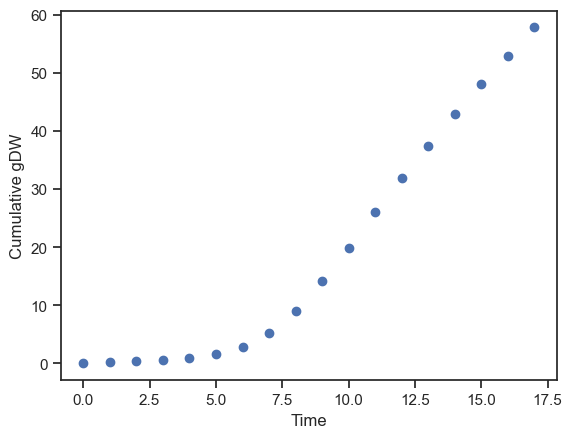

In [59]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Estimate rate by linear regression on initial timepoints for each metabolite
The time limits is determined by inspection of the time-series of each metabolite

In [60]:
specific_limits = {
    'G6P': (1, 10),
    'F6P': (1, 10),
    'FBP': (7, 10),
    'DHAP': (1, 10),
    'GA3P': (1, 10),
    '23PG': (1, 10),
    'PEP': (3, 10),
    'R5P': (1, 10),
    'RU5P+X5P': (3, 10),
    'E4P': (6, 10),
    'CIT': (1, 10),
    'ACN': (1, 10),
    'ICIT': (1, 10),
    'OAS': (1, 7),
    'GLU': (1, 10),
    'SER': (1, 10),
    'ASP': (1, 10),
    'THR': (1, 10),
    'HOM': (1, 10),
    'TYR': (1, 10),
    'GLY': (1, 10),
    'PRO': (1, 8),
    'ALA': (1, 9),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 10),
    'ILEU': (1, 10),
    'LEU': (1, 10),
    'TRP': (1, 6),
    'HIS': (1, 6),
    'ARG': (1, 7),
    'PYR': (1, 8),
    'ORO': (1, 8),
    'FUM': (3, 8),
    'URA': (1, 10),
    'AKG': (7, 10),
    'ACT': (1, 8)
}

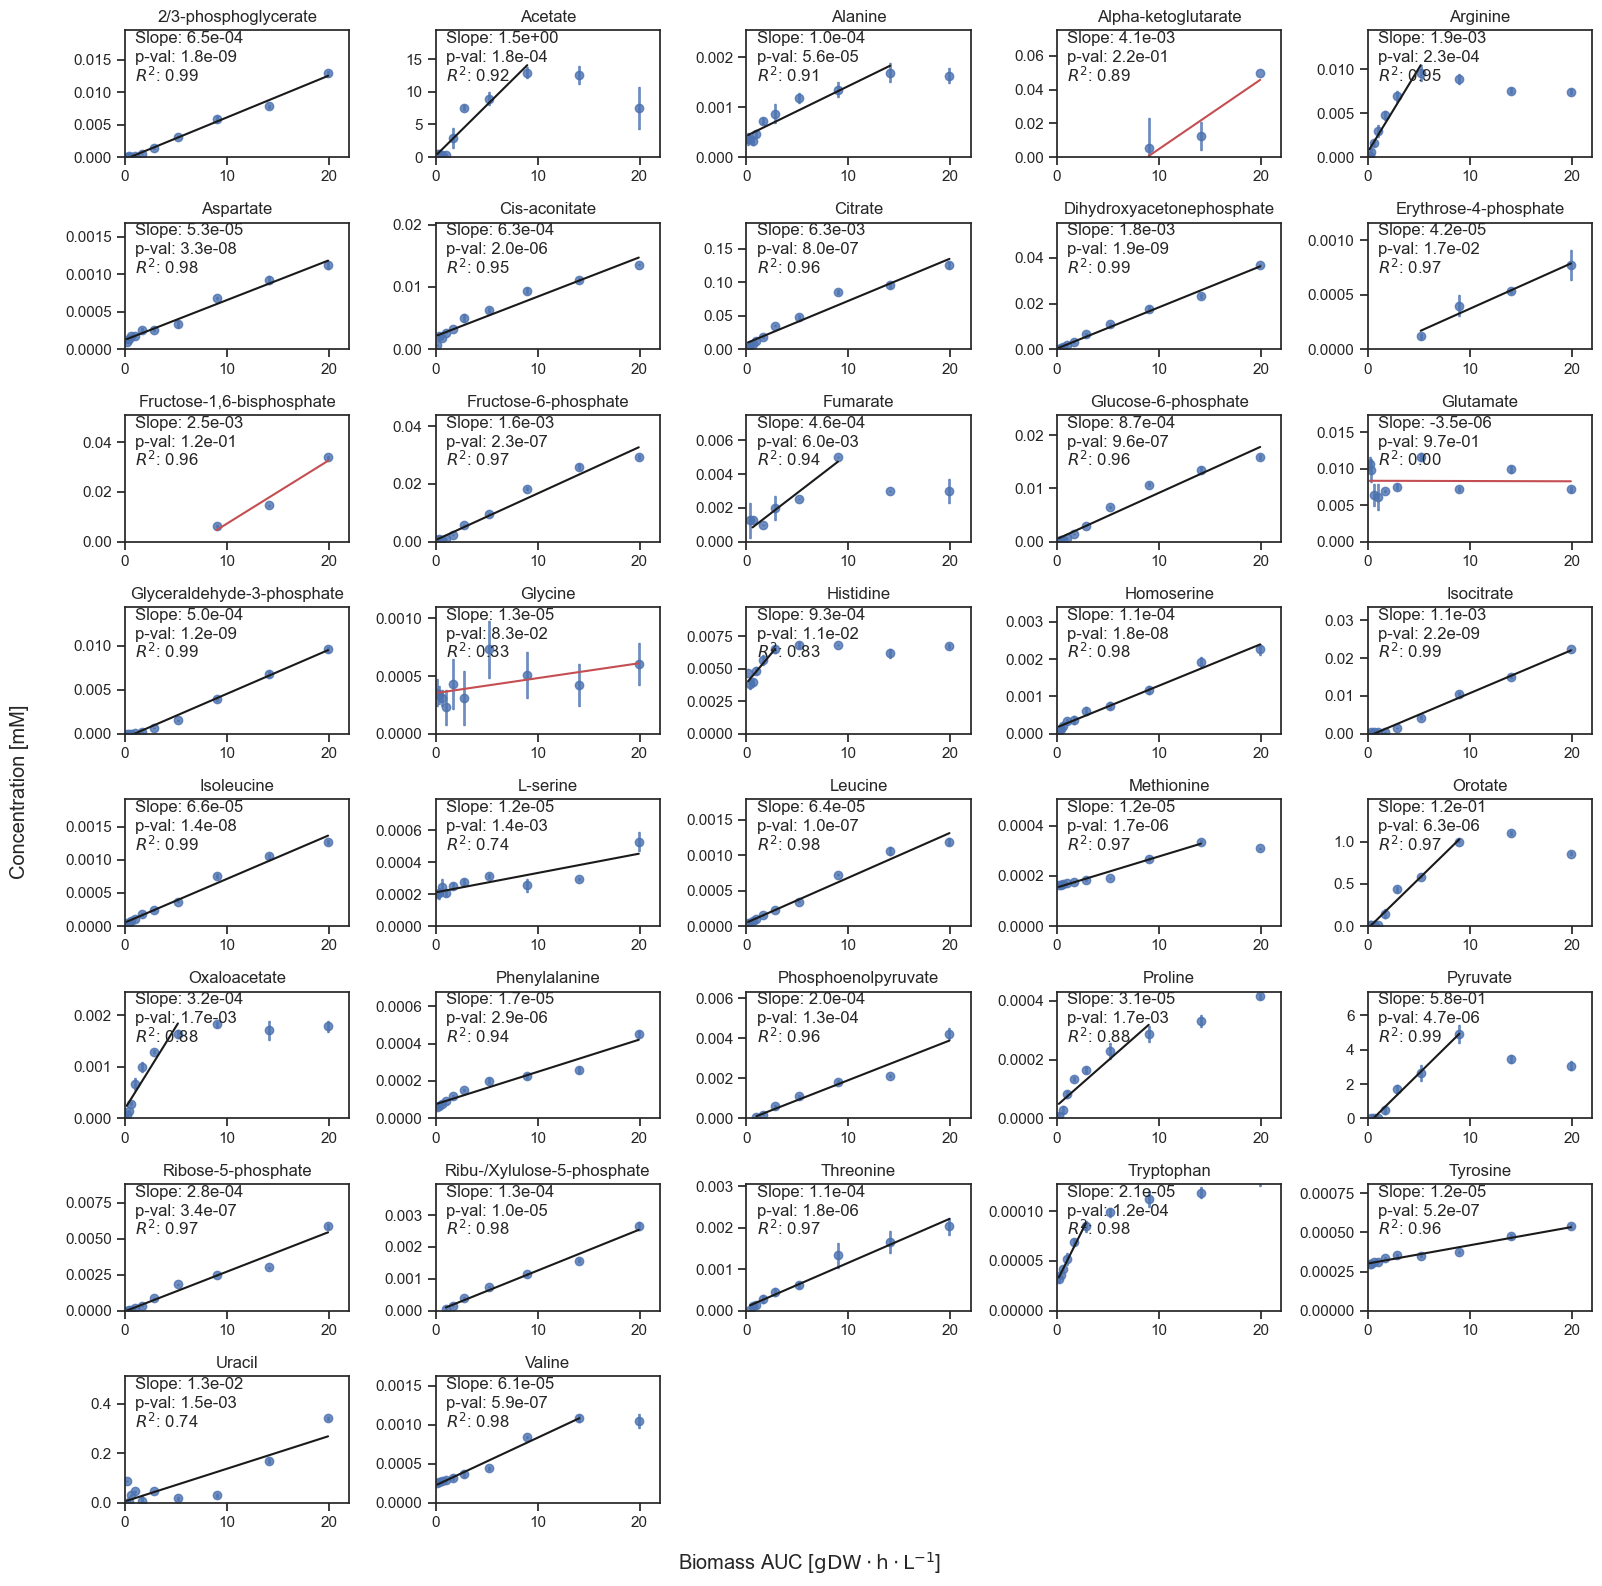

In [86]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
metabolite_names = sorted([met_abrv_to_name[c] for c in concentrations.columns])
for i,metabolite in enumerate(metabolite_names):
    c = met_name_to_abrv[metabolite]
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    conc[conc==0] = np.nan
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1] & np.isfinite(conc)
    rate_conc = conc[idx]

    ax = axes[i]
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    
    if len(rate_conc) >= 3:
        # conc[conc==0] = np.nan
        res = scipy.stats.linregress(x[idx], conc[idx])
        # print(f"R-squared: {res.rvalue**2:.6f}")
        r2 = res.rvalue**2
        data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
        x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
        y_fit = fun(x_fit, res.slope, res.intercept)
    
        if res.pvalue < 0.05:
            ax.plot(x_fit, y_fit, 'k')
        else:
            ax.plot(x_fit, y_fit, 'r')
    else:
        data = [np.nan, np.nan, np.nan, c, np.nan, np.nan]

    data_list.append(data)
    
    ax.set_title(metabolite)
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    if np.isfinite(y_max):
        ax.set_ylim(0, y_max)
    if len(rate_conc) >= 3:
        ax.annotate(f'Slope: {res.slope:.1e}', (1, y_max*0.9))
        ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.75))
        ax.annotate(f'$R^2$: {r2:.2f}', (1, y_max*0.6))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1
met_abrv_to_name
fig.supxlabel(r'Biomass AUC [$\rm{gDW \cdot h \cdot L^{-1}}$]')
fig.supylabel('Concentration [mM]', x = 0)

plt.tight_layout()
# plt.savefig(supp_figure_folder / 'ecoli_paczia_12_fitted_rates_manual_limits.png', dpi = 400)
plt.savefig(supp_figure_folder / 'ecoli_paczia_12_fitted_rates_manual_limits.pdf')
plt.show()

In [62]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

# Subset for figure 1

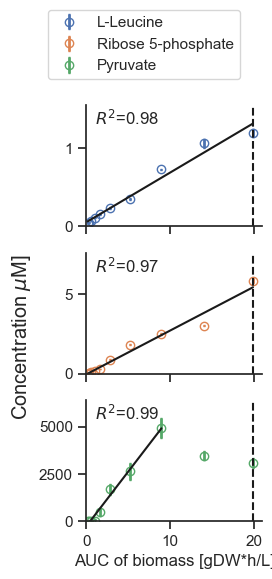

In [63]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}
fig, axes = plt.subplots(3,1, figsize = (3,5), sharex=True)
for i, (c, name) in enumerate(m_abbr_to_name.items()):
    conc = concentrations[c][:-1]
    conc_std = concentrations_std[c][:-1]
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    axes[i].errorbar(x, conc, yerr = conc_std, 
                     fmt='o',color=f'C{i}',capthick=1,elinewidth=2,capsize=1,
                     zorder = 0, label = name, markeredgecolor = f'C{i}', markerfacecolor = 'none')#alpha = 0.8
    res = scipy.stats.linregress(x[idx], conc[idx])
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    
    # axes[i].set_title(name, y = 0.8, size = 10)
    axes[i].set_xlim(0, 21)
    y_max = np.max(conc[idx])*1.3
    axes[i].set_ylim(0, y_max)
    axes[i].plot(x_fit, y_fit, 'k')
    axes[i].axvline(x[10], c = 'k', ls = '--')
    
    # axes[i].annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    # axes[i].annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    r2 = res.rvalue**2
    axes[i].annotate(f'$R^2$={r2:.2f}', (1, y_max*0.84))
axes[i].set_xlabel('AUC of biomass [gDW*h/L]', size = 12)#, y = 0.1)
fig.supylabel(r'Concentration $\mu$M]', x = 0.1)
plt.figlegend(loc = "lower left", bbox_to_anchor = (0.2, 1))

plt.tight_layout()
sns.despine()
# plt.subplots_adjust(bottom = 0.2, left = 0.2)
plt.savefig(figure_folder / 'fitted_rates_for_fig1.pdf', bbox_inches='tight')


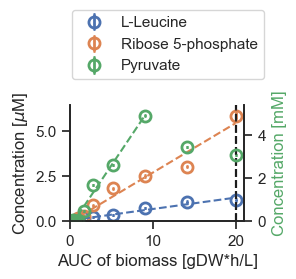

In [64]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}
sns.set(font_scale = 1, style = 'ticks')
fig, ax1 = plt.subplots(1,1, figsize = (3,2), sharex=True)
ax2 = ax1.twinx()
for i, (c, name) in enumerate(m_abbr_to_name.items()):
    conc = concentrations[c][:-1]
    conc_std = concentrations_std[c][:-1]
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if i < 2:
        ax = ax1
    else:
        ax = ax2

    if name == 'Pyruvate':
        # Plot in mM
        conc = conc*1e-3
        conc_std = conc*1e-3
    ax.errorbar(x, conc, yerr = conc_std, 
                     fmt='o',color=f'C{i}',capthick=1,elinewidth=2,capsize=1,
                     zorder = 0, label = name, markeredgecolor = f'C{i}', markerfacecolor = 'none', markersize = 8, markeredgewidth = 2)#alpha = 0.8
    res = scipy.stats.linregress(x[idx], conc[idx])
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    
    # axes[i].set_title(name, y = 0.8, size = 10)
    ax.set_xlim(0, 21)
    y_max = np.max(conc[idx])*1.1
    ax.set_ylim(0, y_max)
    ax.plot(x_fit, y_fit, c = f'C{i}', ls = '--')
    ax.axvline(x[10], c = 'k', ls = '--', zorder = 0, alpha = 0.8)
    
    # axes[i].annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    # axes[i].annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    r2 = res.rvalue**2
    axes[i].annotate(f'$R^2$={r2:.2f}', (1, y_max*0.84))
ax1.set_xlabel('AUC of biomass [gDW*h/L]', size = 12)#, y = 0.1)
ax1.set_ylabel(r'Concentration [$\mu$M]', size = 12)
ax2.set_ylabel(r'Concentration [mM]', size = 12, c = 'C2')
plt.figlegend(loc = "lower left", bbox_to_anchor = (0.2, 1))

plt.tight_layout()
sns.despine(top = True, right = False)
# plt.subplots_adjust(bottom = 0.2, left = 0.2)
plt.savefig(figure_folder / 'fitted_rates_for_fig1_1_panel.pdf', bbox_inches='tight')


# Glucose uptake rates

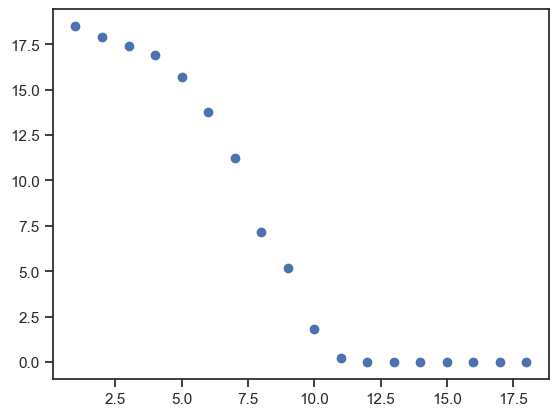

In [65]:
plt.scatter(glucose_df.index, glucose_df['Glucose mean'])

Text(0.5, 0, 'Biomass AUC [gDW*h/L]')

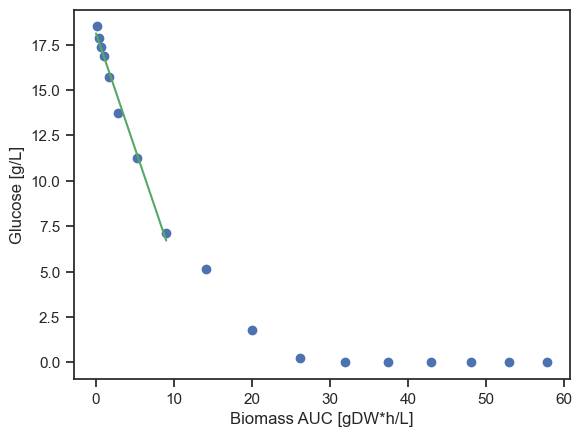

In [66]:
n = 8
res = scipy.stats.linregress(x[1:n+1], glucose_df['Glucose mean'][1:n+1])
fit = [res.slope, res.intercept]
x_fit = np.linspace(0, x[n], 3)
y_fit = fun(x_fit, *fit)
plt.plot(x_fit, y_fit, c = 'C2')
plt.scatter(x, glucose_df['Glucose mean'][:-1])
plt.ylabel('Glucose [g/L]')
plt.xlabel('Biomass AUC [gDW*h/L]')

In [67]:
glc_mw = 180.156
glc_uptake = fit[0]/glc_mw*1e3 # Converting from g/gDW/h to mmol/gDW/h
# print(glc_uptake)
# print(np.sqrt(cov[0][0]))

# Get model

In [68]:
model_ez = reframed.load_cbmodel('../../../models/e_coli/momentiJO1366_modified.xml')
model_ez.solver = 'gurobi'

In [69]:
solution = reframed.FBA(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)})

In [70]:
solution.show_values('EX')

R_EX_ca2_e   -0.00325659
R_EX_cl_e    -0.00325659
R_EX_co2_e    16.5789
R_EX_cobalt2_e -1.56417e-05
R_EX_cu2_e   -0.000443597
R_EX_fe2_e   -0.0100488
R_EX_glc__D_e -7.04358
R_EX_h_e      5.74877
R_EX_h2o_e    33.1026
R_EX_k_e     -0.122126
R_EX_meoh_e   1.25133e-06
R_EX_mg2_e   -0.00542766
R_EX_mn2_e   -0.000432335
R_EX_mobd_e  -8.0711e-05
R_EX_nh4_e   -6.75771
R_EX_ni2_e   -0.00020209
R_EX_o2_e    -15.2438
R_EX_pi_e    -0.603537
R_EX_so4_e   -0.157799
R_EX_zn2_e   -0.000213352
R_HEX1        7.04358


In [71]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

# Shadow prices

In [72]:
shadow_prices = leakage.estimate_shadow_prices_reframed(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)}, metabolites = measured_metabolites)

### Adress uncertainty in shadow price estimates
Use uptake rate +- 20%. This is somewhat arbitrary,but is a very conservative estimate that covers different "steps" on the ladder of reduced metabolite value

In [73]:
glc_uptake_range = np.linspace(glc_uptake*1.2, glc_uptake*0.8, 5, endpoint=True)
shadow_price_list = []
for g in glc_uptake_range:
    shadow_prices_i = leakage.estimate_shadow_prices_reframed(model_ez, constraints={'R_EX_glc__D_e': (g,0)}, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)

In [74]:
shadow_price_list.append(shadow_prices)

In [75]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Turnover

In [76]:
solution = reframed.pFBA(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)})
turnover = solution.get_metabolites_turnover(model_ez)

    

In [77]:
# The turnover of fdp is 0 because the model predicts that F6PA is used instead of FBA . Unlikely, e.g. https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-7-33
solution.show_metabolite_balance('M_fdp_c', model_ez)

# Make spreadsheet

In [79]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std. Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if np.isnan(row['Rate [mmol/gDW/h]']):
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std. Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = utils.get_mol_weight(m)
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'Model ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']


In [80]:
for idx, row in df_rate.iterrows():
    if row['Model ID'] == '2pg':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to 2-phosphoglycerate')
        df_rate.loc[idx, 'Metabolite'] = '2-phosphoglycerate'
        
    if row['Model ID'] == '3pg':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to 3-phosphoglycerate')
        df_rate.loc[idx, 'Metabolite'] = '3-phosphoglycerate'

    if row['Model ID'] == 'ru5p__D':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Ribulose-5-phosphate')
        df_rate.loc[idx, 'Metabolite'] = 'Ribulose-5-phosphate'
        
    if row['Model ID'] == 'xu5p__D':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Xylulose-5-phosphate')
        df_rate.loc[idx, 'Metabolite'] = 'Xylulose-5-phosphate'



2/3-phosphoglycerate Changed 0 to 2-phosphoglycerate
2/3-phosphoglycerate Changed 1 to 3-phosphoglycerate
Ribu-/Xylulose-5-phosphate Changed 32 to Ribulose-5-phosphate
Ribu-/Xylulose-5-phosphate Changed 33 to Xylulose-5-phosphate


In [81]:
df_rate['Species'] = 'E. coli'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [82]:
df_rate.to_csv(data_folder / 'paczia_2012' / 'paczia_12_rates_ecoli.csv')

# Estimate shadow prices without enzyme constraints

In [37]:
model0 = model_ez.copy()

In [38]:
model0.reactions.R_ER_pool_TG_

R_ER_pool_TG_:  --> M_prot_pool [0.0, 0.095]

In [39]:
shadow_prices0 = leakage.estimate_shadow_prices_reframed(model0, constraints={'R_EX_glc__D_e': (glc_uptake,0), 'R_ER_pool_TG_':(0, 1000)}, metabolites = measured_metabolites)

In [40]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std. Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std. Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices0[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([abbr, bigg_id, name, mv, Nc, mass, rate_i, std_err_i, row['R2']])
df_rate0 = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'Model ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']


NameError: name 'ng_utils' is not defined

In [ ]:
df_rate0.to_csv('paczia_13_rates_ecoli_0824_no_enz.csv')